In [3]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"
import netket as nk
import numpy as np
import matplotlib.pyplot as plt
import jax
import pandas as pd
import netket.nn as nknn
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt 
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [4]:
#Couplings J1 and J2
J = [-0.515038, -0.857167]	
L = 8

In [5]:
# Define custom graph
edge_colors = []
for i in range(L):
    edge_colors.append([i, (i+1)%L, 1])
    edge_colors.append([i, (i+2)%L, 2])
# Define the netket graph object
g = nk.graph.Graph(edges=edge_colors)

#Sigma^z*Sigma^z interactions
sigmaz = [[1, 0], [0, -1]]
mszsz = (np.kron(sigmaz, sigmaz))
exchange = np.asarray([[0, 0, 0, 0], [0, 0, 2, 0], [0, 2, 0, 0], [0, 0, 0, 0]])

bond_operator = [
    (J[0] * mszsz).tolist(),
    (J[1] * mszsz).tolist(),
    (-J[0] * exchange).tolist(),  
    (J[1] * exchange).tolist(),
]

bond_color = [1, 2, 1, 2]
hi = nk.hilbert.Spin(s=0.5, total_sz=0.0, N=g.n_nodes)

In [6]:
op = nk.operator.GraphOperator(hi, graph=g, bond_ops=bond_operator, bond_ops_colors=bond_color)

In [7]:
class FFNN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=2*x.shape[-1], 
                     use_bias=True, 
                     param_dtype=np.complex128, 
                     kernel_init=nn.initializers.normal(stddev=0.01), 
                     bias_init=nn.initializers.normal(stddev=0.01)
                    )(x)
        x = nknn.log_cosh(x)
        x = jnp.sum(x, axis=-1)
        return x

model = FFNN()

In [8]:
sa = nk.sampler.MetropolisExchange(hilbert=hi, graph=g, d_max = 2)
vs = nk.vqs.MCState(sa, model, n_samples=1008)
opt = nk.optimizer.Sgd(learning_rate=0.01)
sr = nk.optimizer.SR(diag_shift=0.01)
gs = nk.VMC(hamiltonian=op, optimizer=opt, variational_state=vs, preconditioner=sr)

In [9]:
vs

MCState(
  hilbert = Spin(s=1/2, total_sz=0.0, N=8),
  sampler = MetropolisSampler(rule = ExchangeRule(# of clusters: 28), n_chains = 16, n_sweeps = 8, reset_chains = False, machine_power = 2, dtype = <class 'float'>),
  n_samples = 1008,
  n_discard_per_chain = 100,
  sampler_state = MetropolisSamplerState(rng state=[2722619950 1361817407]),
  n_parameters = 144)

In [10]:
vs_i_parameters = vs.parameters.copy()

In [11]:
vs_i_parameters['Dense_0']['bias']

Array([-0.00485956+0.00124961j, -0.0120814 -0.0040704j ,
       -0.00570052+0.01194502j,  0.00137777+0.00425435j,
        0.00612127+0.00095368j,  0.00718657+0.00261493j,
        0.00281131-0.00811184j, -0.00872417+0.00020763j,
        0.00879509-0.00363082j,  0.00055347+0.0021493j ,
        0.00495807+0.01160861j,  0.00176669-0.01198278j,
        0.01006506+0.01235707j,  0.00921936+0.00081867j,
       -0.00521336-0.00733226j, -0.0048718 +0.00443844j],      dtype=complex128)

In [12]:
# Define a função de perda (loss function) para o treinamento
def loss(params, structure_factor):
    output = model.apply({'params': params}, structure_factor)
    return jnp.mean(output)
# Função de callback para salvar os parâmetros durante o treinamento
def save_params(step, params, energy):
    trained_params_list.append(params.copy())
    parameters_list.append(energy.state.parameters.copy())
    iii.append(1)
    return True

In [13]:
sf = []
sites = []
structure_factor = nk.operator.LocalOperator(hi, dtype=complex)
for i in range(0, L):
    for j in range(0, L):
        structure_factor += (nk.operator.spin.sigmaz(hi, i)*nk.operator.spin.sigmaz(hi, j))*((-1)**(i-j))/L

# Define uma lista para armazenar os parâmetros do modelo durante o treinamento
trained_params_list = []
parameters_list     = []
iii                 = []

In [14]:
gs.run(out='test', n_iter=300, obs={'Structure Factor': structure_factor}, callback=save_params)

100%|█████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:16<00:00, 18.66it/s, Energy=-10.97780+0.00014j ± 0.00040 [σ²=0.00016, R̂=1.0143]]


(JsonLog('test', mode=write, autoflush_cost=0.005)
   Runtime cost:
   	Log:    0.06065201759338379
   	Params: 0.0012314319610595703,)

In [16]:
vs.parameters['Dense_0']['bias']

Array([ 0.00054897-0.00106026j, -0.00386134+0.00868942j,
       -0.00534988+0.00960606j,  0.00675817-0.00027333j,
       -0.00024916+0.00472751j,  0.00066463+0.00088619j,
       -0.00944585-0.01028767j, -0.01727315-0.0030867j ,
        0.01555778-0.003412j  , -0.00594686-0.00284294j,
        0.01106733+0.00450937j,  0.0199016 -0.0154778j ,
        0.00898284-0.00292116j, -0.00523321+0.00704067j,
       -0.00538665-0.00547816j, -0.01182908+0.011466j  ],      dtype=complex128)

In [17]:
len(parameters_list)

300

In [18]:
parameters_list[-1]['Dense_0']['bias']

Array([ 0.00055144-0.00107216j, -0.00386562+0.00868011j,
       -0.00535994+0.00960137j,  0.00675614-0.00027209j,
       -0.0002469 +0.00472356j,  0.00067264+0.00088324j,
       -0.00946971-0.01028429j, -0.01727293-0.00307289j,
        0.01556378-0.00340775j, -0.00592604-0.00284145j,
        0.01106938+0.00450989j,  0.01992168-0.01549015j,
        0.00898849-0.00292587j, -0.00525678+0.00705251j,
       -0.0053822 -0.00546643j, -0.01184538+0.011469j  ],      dtype=complex128)

In [19]:
def info(e):
    head   = list(e.keys())[0]
    body   = list(e[head].keys())
    bias   = e[head][body[0]]
    kernel = e[head][body[1]]
    return  head, body, list(bias), list(kernel)
def real(c):
    return float(np.real(c))  
def img(c):
    return float(np.imag(c))    
def r_i(c):
    return real(c),img(c)   

In [20]:
head, body, bias_list,kernel_list = info(parameters_list[-1])

In [21]:
len(bias_list)

16

In [22]:
real_df = pd.DataFrame()
img_df  = pd.DataFrame()
for param in parameters_list:
    head, body, bias_list,kernel_list = info(param)
    real_v = [];img_v = []
    for bias in bias_list:
        nr, ni = r_i(bias); 
        real_v.append(nr)
        img_v.append(ni)   
    
    real_row_df = pd.DataFrame([real_v])
    img_row_df  = pd.DataFrame([img_v])
        
    real_df = pd.concat([real_df,real_row_df])
    img_df  = pd.concat([img_df,img_row_df])   

In [23]:
real_df.shape

(300, 16)

In [24]:
img_df.shape

(300, 16)

In [25]:
real_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.004860,-0.012081,-0.005701,0.001378,0.006121,0.007187,0.002811,-0.008724,0.008795,0.000553,0.004958,0.001767,0.010065,0.009219,-0.005213,-0.004872
0,-0.006062,-0.013922,-0.004627,0.002542,0.005897,0.004613,0.002684,-0.007166,0.008409,0.001678,0.004844,0.001877,0.010998,0.009342,-0.004510,-0.005051
0,-0.007979,-0.014379,-0.003731,0.003748,0.005853,0.001411,0.001997,-0.006602,0.008604,0.001886,0.003722,0.000642,0.010005,0.010517,-0.004550,-0.003617
0,-0.008578,-0.013546,-0.003263,0.003398,0.005778,0.000981,0.001933,-0.005595,0.009030,0.001791,0.003298,0.000410,0.008844,0.009498,-0.005349,-0.002572
0,-0.007695,-0.012602,-0.003008,0.002093,0.006035,0.001622,0.001356,-0.004215,0.008982,0.001356,0.003042,0.001033,0.008593,0.007118,-0.006645,-0.002516


In [26]:
real_df.columns

RangeIndex(start=0, stop=16, step=1)

In [27]:
real_df.insert(0, 'id', range(1, 1 + len(real_df)))

In [28]:
real_df.columns

Index(['id', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], dtype='object')

In [29]:
img_df.insert(0, 'id', range(1, 1 + len(img_df)))

In [30]:
img_df.head()

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1,0.001250,-0.004070,0.011945,0.004254,0.000954,0.002615,-0.008112,0.000208,-0.003631,0.002149,0.011609,-0.011983,0.012357,0.000819,-0.007332,0.004438
0,2,0.001213,-0.003537,0.013035,0.002409,0.000162,0.002897,-0.011235,0.000321,-0.003386,-0.000305,0.011073,-0.010537,0.012616,0.001714,-0.006020,0.003493
0,3,0.001065,-0.002959,0.012171,0.002692,0.000797,0.003417,-0.012080,-0.000114,-0.002637,0.001495,0.010787,-0.010519,0.012120,0.001924,-0.006110,0.003419
0,4,0.000479,-0.002347,0.011126,0.002843,0.000801,0.004254,-0.012215,0.000194,-0.002101,0.003215,0.010779,-0.010453,0.011843,0.001711,-0.005481,0.003350
0,5,0.000091,-0.001617,0.011286,0.002844,0.000819,0.003815,-0.012069,0.000811,-0.001874,0.003196,0.010485,-0.010409,0.011403,0.001446,-0.005959,0.003797


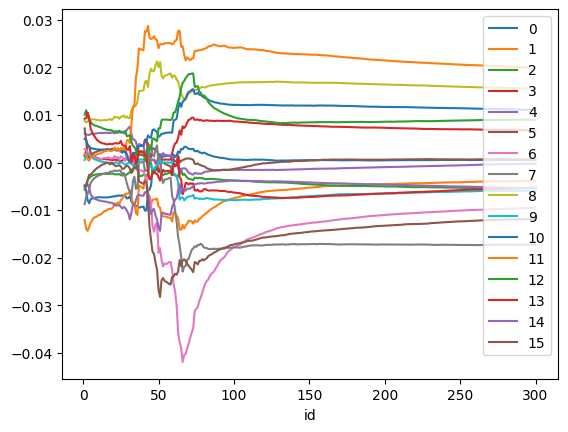

In [31]:
real_df.plot('id',y=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
plt.show()


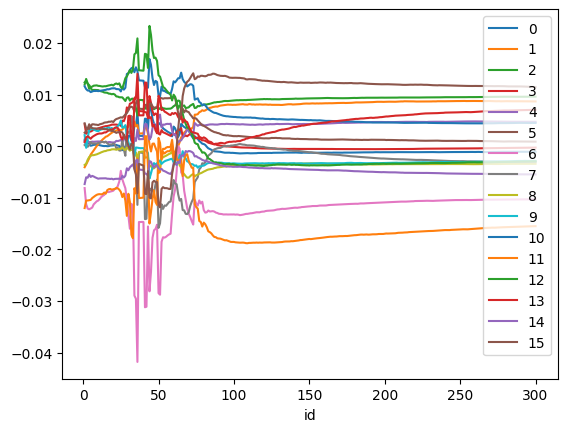

In [32]:
img_df.plot('id',y=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
plt.show()

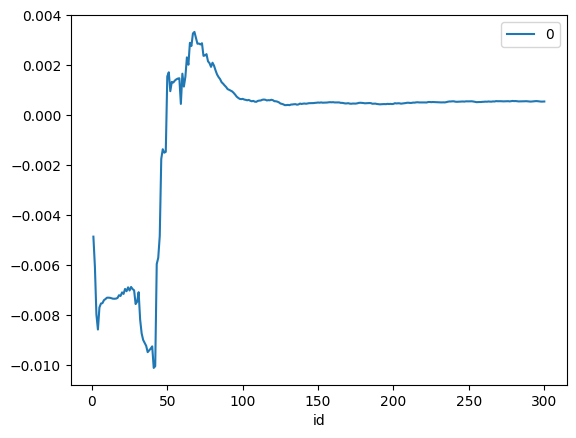

In [33]:
real_df.plot('id',y=[0])
plt.show()

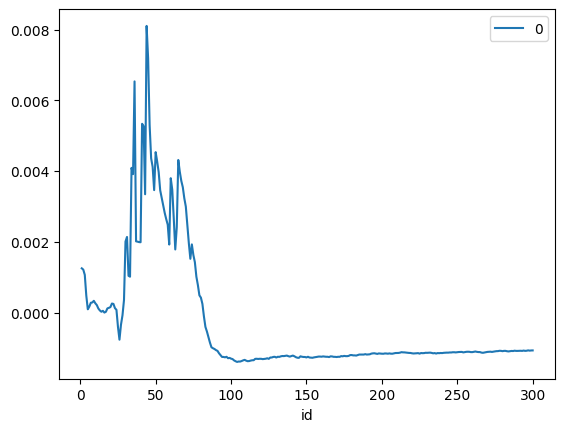

In [35]:
img_df.plot('id',y=[0])
plt.show()

In [36]:
len(kernel_list)

8

In [37]:
len(kernel_list[0])

16

In [38]:
(kernel_list[0][0])

Array(0.00024465-0.02180247j, dtype=complex128)

In [39]:
real_kernel_df = pd.DataFrame()
img_kernel_df  = pd.DataFrame()
for param in parameters_list:
    head, body, bias_list,kernel_list = info(param)
    real_v = [];img_v = []
    for ks in kernel_list:
        for k in ks:
            nr, ni = r_i(k); 
            real_v.append(nr)
            img_v.append(ni) 
    real_row_df = pd.DataFrame([real_v])
    img_row_df  = pd.DataFrame([img_v])
    
    real_kernel_df = pd.concat([real_kernel_df,real_row_df])
    img_kernel_df  = pd.concat([img_kernel_df,img_row_df])   

In [40]:
real_kernel_df.insert(0, 'id', range(1, 1 + len(real_kernel_df)))
img_kernel_df.insert(0, 'id', range(1, 1 + len(img_kernel_df)))

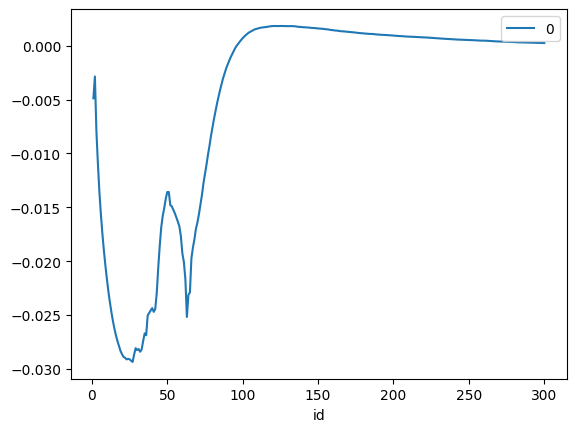

In [41]:
real_kernel_df.plot('id',y=[0])
plt.show()

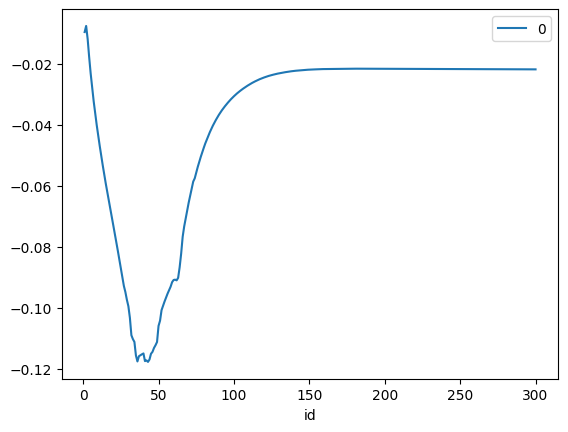

In [42]:
img_kernel_df.plot('id',y=[0])
plt.show()

In [43]:
img_kernel_df.columns

Index(['id',    0,    1,    2,    3,    4,    5,    6,    7,    8,
       ...
        118,  119,  120,  121,  122,  123,  124,  125,  126,  127],
      dtype='object', length=129)

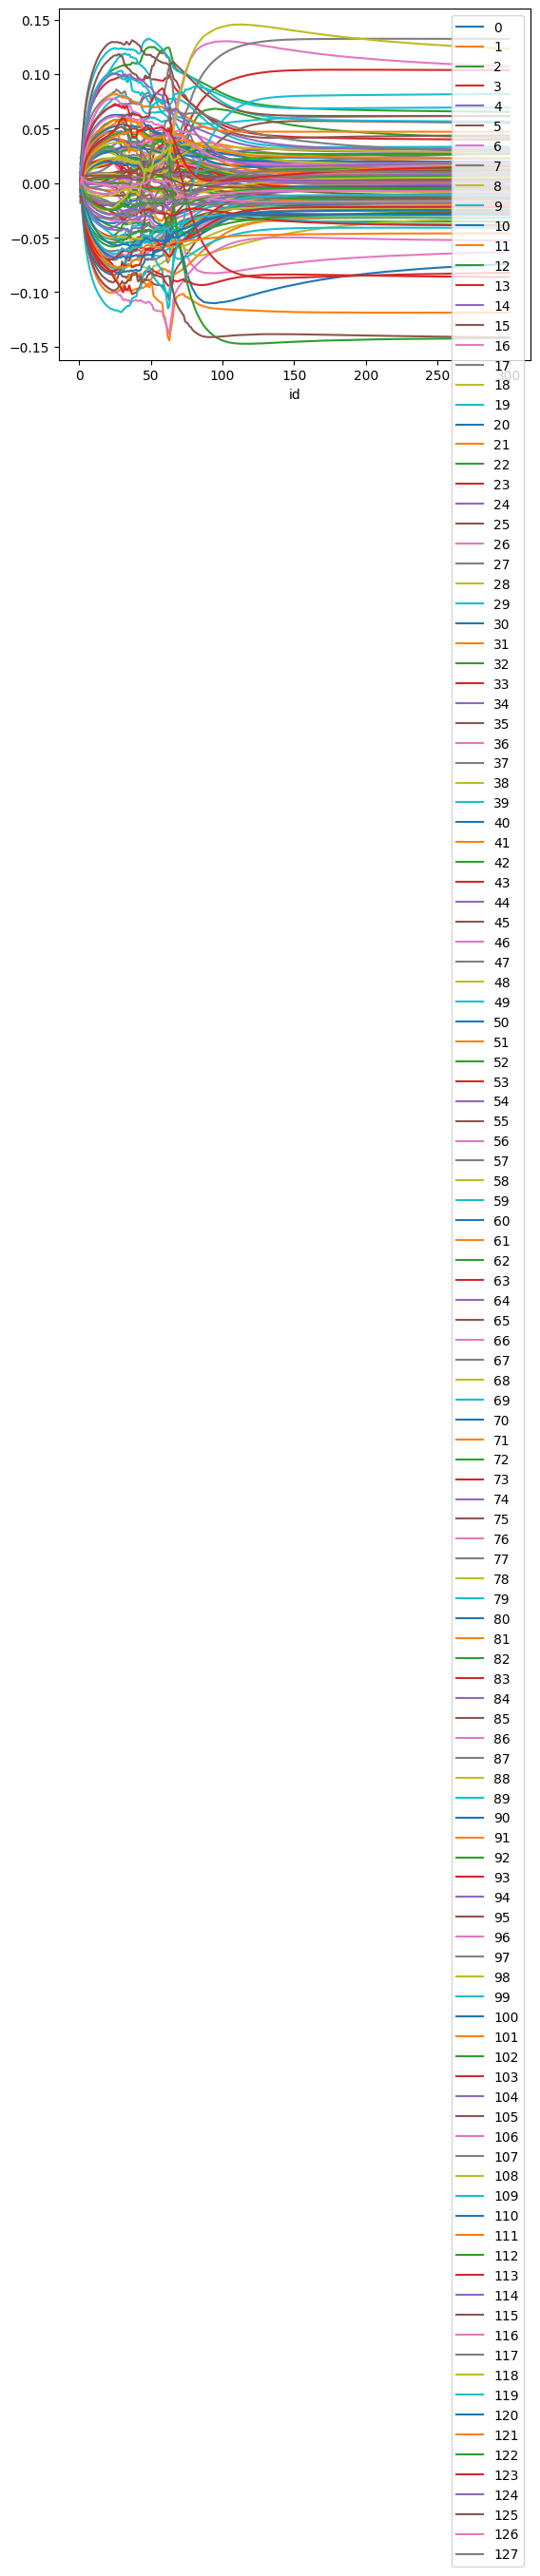

In [49]:
yt = []
for i in range(0,128): 
    yt.append(i)  
real_kernel_df.plot('id',y=yt)
plt.show()

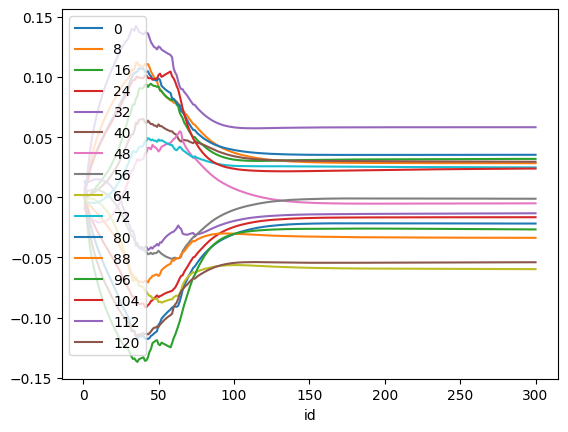

In [44]:
yt = []
for i in range(0,128): 
    if i % 8 ==0:
        yt.append(i)  
img_kernel_df.plot('id',y=yt)
plt.show()

In [45]:
yt = []
for i in range(0,128): 
    yt.append(i)        

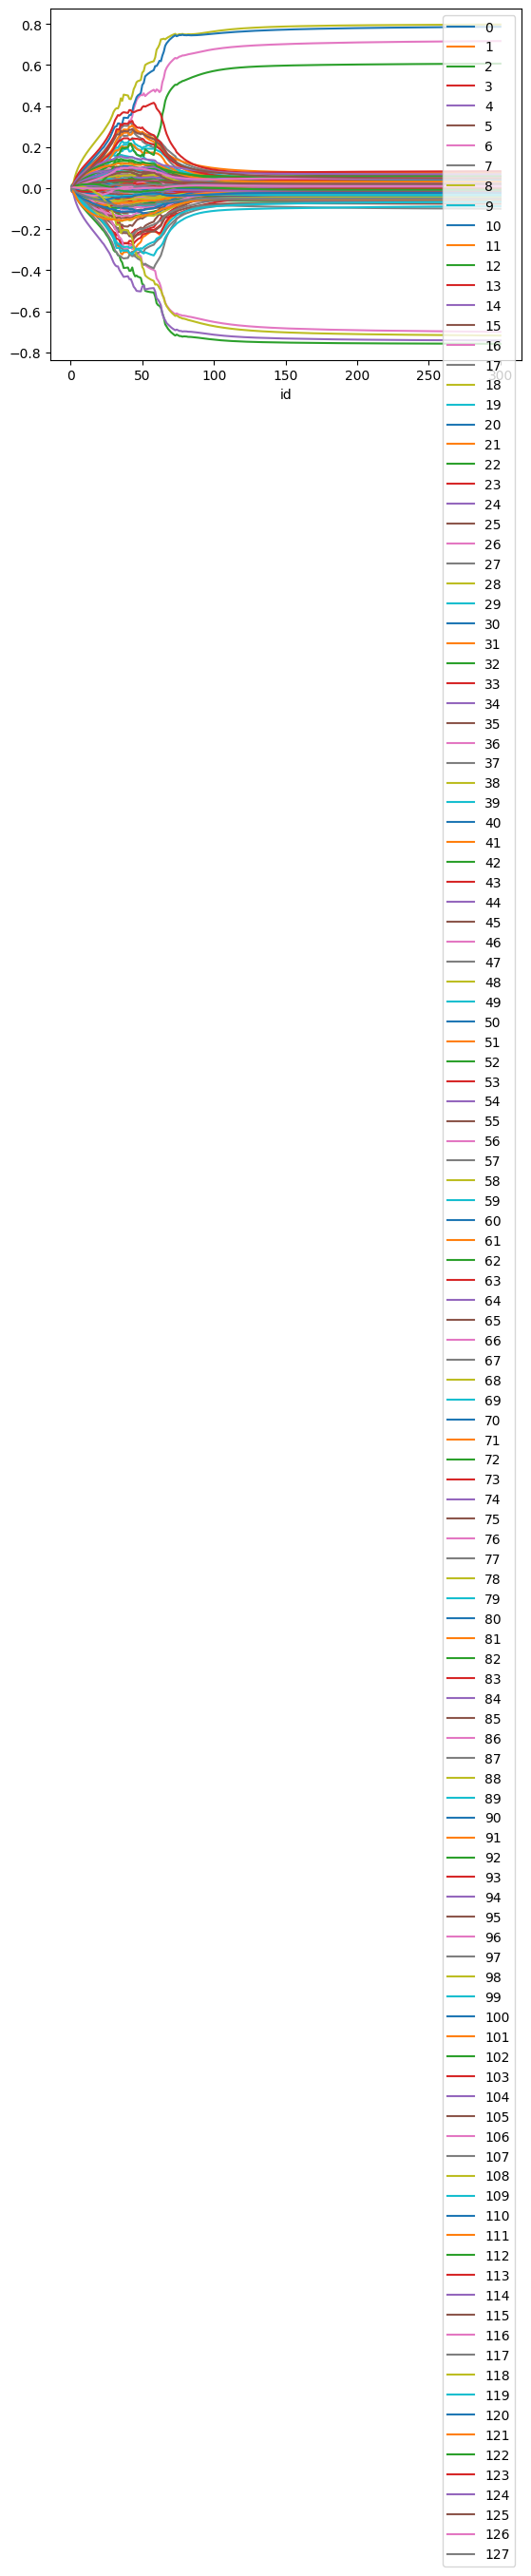

In [46]:
img_kernel_df.plot('id',y=yt)
plt.show()

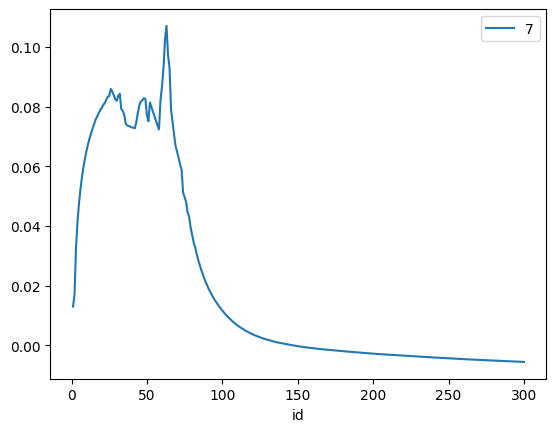

In [47]:
real_kernel_df.plot('id',y=[7])
plt.show()

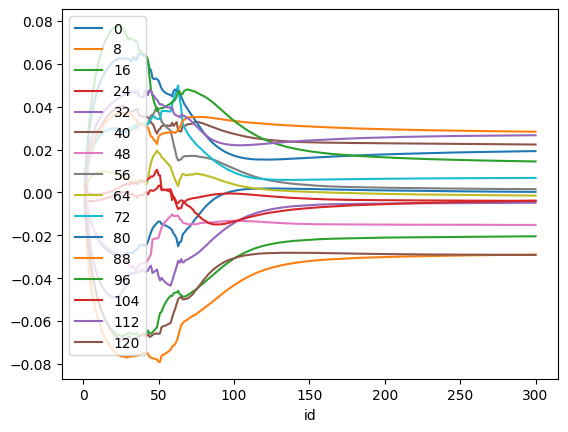

In [48]:
yt = []
for i in range(0,128): 
    if i % 8 ==0:
        yt.append(i)  
real_kernel_df.plot('id',y=yt)
plt.show()